In [75]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
# preparing data
from sklearn.decomposition import PCA

from models import *
from methods import *
from datasetPreProcessing import LoadDatasetByName
import pandas as pd
import numpy as np
import torch
import math
import os
from os import path
import torch.nn as nn

model_name = "DSVDD"
DATASET = 'ECU_IoHT_data'
DATASET = 'medical_data'

"""___________________Hyper Parameters________________________"""
CROSS_VALIDATION_SHUFFLE = True
TRIM_DATA = True
FILTER_CORRCOEF = True
REMOVE_NOISE = False
REMOVE_NOISE_THRESHOLD = 5
DENOISE = False
NOISE_FACTOR = 0.05
NOISE_FRACTION = 0.8
NORMALIZE_DATA = True
NORMALIZATION_SCHEME = 'standard_scaling'
#NORMALIZATION_SCHEME = 'quantile_transform_normal'
LATENT_DIM = 8
HIDDEN_DIM = 16
WEIGHT_DECAY = 0e-7
LEARNING_RATE = 1e-3
EPOCHS = 10000
ACTIVATION = 'leaky_relu'
BATCH_SIZE = 1024
INITIALIZATION = 'xavier_normal'
ALGO = 'SGD'
v = 50e-0
OUTPUT_FEATURE = 4
GAMMA = 0
"""___________________________________________________________"""
#device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

"""______________________________________Dataset___________________________________________"""
# Load Dataset
raw_data, anomalous_data, features, categorical_data_index = LoadDatasetByName(DATASET)

train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_data, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA, normalization_scheme=NORMALIZATION_SCHEME,
            filterLinearDependencies=True, filter_threshold=0.98, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD, categorical_data_index=categorical_data_index)

train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
"""________________________________________________________________________________________"""
NUM_FEATURE = len(train_data[0])
print(train_data.shape)
print(torch.max(anomalous_data))

Untrimmed columns:  [0, 1, 2, 3, 4, 5, 6]
Train data shape after trim:  (8005, 7)
Train data shape after filter corrcoef:  (8005, 7)
Normalization scheme:  standard_scaling
Train data shape after normalize:  (8005, 7)
torch.Size([8005, 7])
tensor(7.4328)


In [77]:
# initialize model
criterion = lambda *args: 0
R = torch.tensor(1, dtype=float, requires_grad=True)
model = DSVDD(NUM_FEATURE, output_feature=OUTPUT_FEATURE, center=torch.tensor([[0]]), v=v, R=R, gamma=1e-0, hidden_dim=HIDDEN_DIM, activation=ACTIVATION, initialization=INITIALIZATION,)

In [78]:
# train
loss_array = train(model, ALGO, EPOCHS, train_data, train_data, criterion, batch_size=BATCH_SIZE, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        ,grad_limit=1e2,)
torch.save(model.state_dict(), '../model/param_AE')

epoch : 1/10000, loss = 0.083824
epoch : 2/10000, loss = 0.081226
epoch : 3/10000, loss = 0.078858
epoch : 4/10000, loss = 0.076688
epoch : 5/10000, loss = 0.074689
epoch : 6/10000, loss = 0.072846
epoch : 7/10000, loss = 0.071142
epoch : 8/10000, loss = 0.069561
epoch : 9/10000, loss = 0.068085
epoch : 10/10000, loss = 0.066707
epoch : 11/10000, loss = 0.065414
epoch : 12/10000, loss = 0.064194
epoch : 13/10000, loss = 0.063042
epoch : 14/10000, loss = 0.061948
epoch : 15/10000, loss = 0.060910
epoch : 16/10000, loss = 0.059920
epoch : 17/10000, loss = 0.058989
epoch : 18/10000, loss = 0.058096
epoch : 19/10000, loss = 0.057233
epoch : 20/10000, loss = 0.056408
epoch : 21/10000, loss = 0.055634
epoch : 22/10000, loss = 0.054881
epoch : 23/10000, loss = 0.054154
epoch : 24/10000, loss = 0.053457
epoch : 25/10000, loss = 0.052788
epoch : 26/10000, loss = 0.052155
epoch : 27/10000, loss = 0.051534
epoch : 28/10000, loss = 0.050934
epoch : 29/10000, loss = 0.050353
epoch : 30/10000, loss 

torch.Size([1137, 7])
Train average loss:0.0
Train code square: tensor([[0.0006],
        [0.0006],
        [0.0095],
        ...,
        [0.0006],
        [0.0006],
        [0.0015]], grad_fn=<SumBackward1>)
Train error: 3.586207299569184, Train R square: 0.01185204375677755
Validation average loss:0.0
Test average loss:  0.0
Anomalous average loss:  0.0

Train code outside hypersphere percentage: 0.048594653606414795
Validation code outside hypersphere percentage: 0.058448851108551025
Test code outside hypersphere percentage: 0.05357813835144043
Anomalous code outside hypersphere percentage: 0.0932278037071228



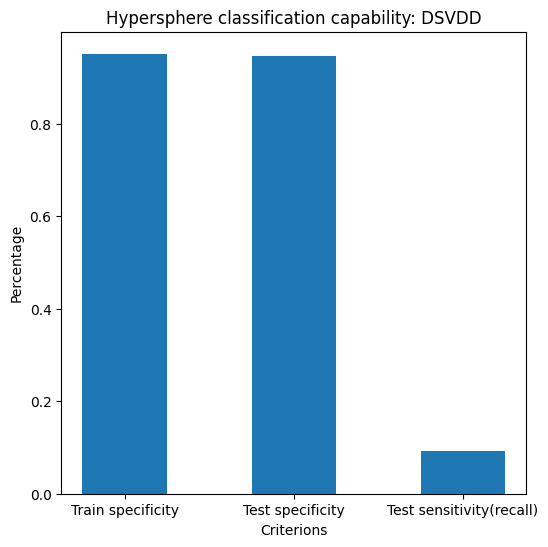

In [79]:
# evaluation
print(anomalous_data.shape)
model.eval()

train_code = model(train_data)
train_code_square = torch.sum((train_code - model.center) ** 2, dim=1, keepdim=True)
print(f"Train average loss:{criterion(model(train_data), train_data) / len(train_data)}")
print(f"Train code square: {train_code_square}")
print(f"Train error: {model.error}, Train R square: {model.R.item() ** 2}")

print(f"Validation average loss:{criterion(model(validation_data), validation_data) / len(validation_data)}")
print("Test average loss: ", criterion(model(test_data), test_data)/len(test_data))
print("Anomalous average loss: ", criterion(model(anomalous_data), anomalous_data)/len(anomalous_data))
train_specificity, test_specificity, test_sensitivity = model.insidePercentage(train_data), model.insidePercentage(test_data), 1-model.insidePercentage(anomalous_data)
print(f"\nTrain code outside hypersphere percentage: {1-train_specificity}")
print(f"Validation code outside hypersphere percentage: {1-model.insidePercentage(validation_data)}")
print(f"Test code outside hypersphere percentage: {1-model.insidePercentage(test_data)}")
print(f"Anomalous code outside hypersphere percentage: {test_sensitivity}\n")
d = {"Train specificity":train_specificity, 
    "Test specificity":test_specificity, 
    "Test sensitivity(recall)":test_sensitivity}
plot_bar(d, model_name, False, save_path='../graphs/DSVDD/sensitivity_specificity')

In [80]:
# use TSNE to show code distribution
PERPLEXITY = 10
if True:
    model.eval()
    full_code = model(torch.cat((test_data, anomalous_data), dim=0)).detach().numpy()
    full_label = [0 for _ in range(len(test_data))] + [1 for _ in range(len(anomalous_data))]
    from sklearn.manifold import TSNE

    # We want to get TSNE embedding with 2 dimensions
    n_components = 2
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    #print(full_data.shape)
    tsne_code = tsne.fit_transform(full_code)
# use TSNE to show LCS 
if False:
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    full_lcs = np.concatenate((lcs_array_test, lcs_array_attack), axis=0)
    #print(full_data.shape)
    tsne_lcs = tsne.fit_transform(full_lcs)

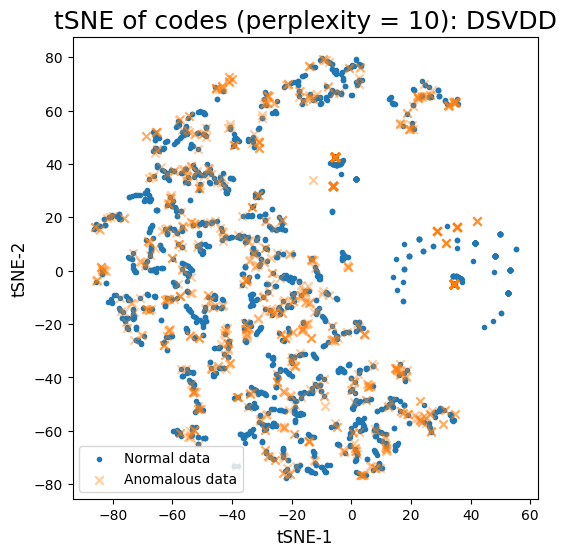

In [81]:
import matplotlib.pyplot as plt
plot1_upper_lim = 1e12
plot1_lower_lim = 0e-1
if True:
    # Plot the result of our TSNE with the label color coded
    fig3 = plt.figure(figsize = (6,6))
    ax3 = fig3.add_subplot(1,1,1
    #, projection='2d'
    )
    l1, l2 = len(test_data), len(anomalous_data)
    ax3.scatter(tsne_code[:l1,0], tsne_code[:l1,1], marker=".").set_label('Normal data')
    ax3.scatter(tsne_code[l1:,0], tsne_code[l1:,1], marker="x", alpha=0.4).set_label('Anomalous data')
    ax3.set_title(('tSNE of codes (perplexity = ' + str(PERPLEXITY) + '): ' + model_name), fontsize = 18)
    ax3.set_xlabel('tSNE-1', fontsize = 12)
    ax3.set_ylabel('tSNE-2', fontsize = 12)
    ax3.legend()

<Figure size 500x500 with 0 Axes>

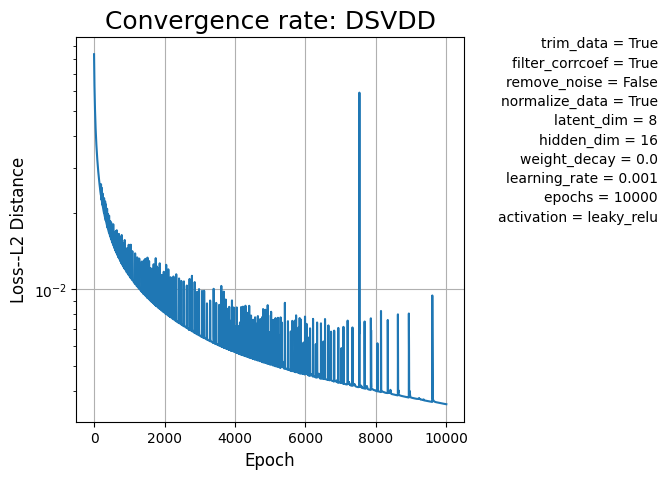

In [82]:
# convergence
def visualize_convergence(loss_array,  model_name:str, save:bool=False, **kwargs):
    fig = plt.figure(figsize = (5, 5))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Epoch', fontsize = 12)
    ax.set_ylabel('Loss--L2 Distance', fontsize = 12)
    ax.set_yscale('log')
    ax.set_title('Convergence rate: ' + model_name, fontsize = 18)
    ax.grid()
    ax.plot(loss_array)
    # annotate graph
    x, y, i = 1.5, 1, 1
    for key, value in kwargs.items():
        ax.text(x, y, str(key) + " = " + str(value), ha='right', va='top', transform = ax.transAxes)
        y -= 0.05
    # save graph
    if save:
        path = "../graphs/Convergence"
        filename = model_name
        pathfile = os.path.normpath(os.path.join(path, filename))
        if not os.path.exists(path):
            os.makedirs(path)
        while os.path.isfile(pathfile + '.png'):
            pathfile = os.path.normpath(os.path.join(path, filename + str(i)))
            i += 1
        fig.savefig(pathfile)
    return ax

fig = plt.figure(figsize = (5, 5))
parameters = {"trim_data": TRIM_DATA, "filter_corrcoef": FILTER_CORRCOEF, "remove_noise": REMOVE_NOISE,
"normalize_data": NORMALIZE_DATA,
"latent_dim": LATENT_DIM,
"hidden_dim": HIDDEN_DIM,
"weight_decay": WEIGHT_DECAY,
"learning_rate": LEARNING_RATE,
"epochs": EPOCHS,   
"activation": ACTIVATION}
ax = visualize_convergence(loss_array, model_name, save=True, **parameters)

In [83]:
# classify data
if DATASET == 'network_data' and False:
    model.load_state_dict(torch.load('../model/param_DOCAE_8_8'))
    model.eval()
    anomalous_data = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_data, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA,
                filterLinearDependencies=True, filter_threshold=0.97, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD)
    anomalous_data = torch.tensor(anomalous_data).to(torch.float).to(device)
    idc_to_save = (torch.sum(model.encode(anomalous_data)**2, dim=1) <= model.R**2)
    print(idc_to_save.shape)
    #df = pd.DataFrame(np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[idc_to_save,]) #convert to a dataframe
    #df.to_csv('../data/network_flow_attack_data_undetected.csv', index=False) #save to file

    #df = pd.DataFrame(anomalous_data[idc_to_save,]) #convert to a dataframe
    #df.to_csv('../data/network_flow_attack_data_temp_undetected.csv', index=False) #save to file

    medical_data = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')
    df = pd.DataFrame(medical_data[idc_to_save,]) #convert to a dataframe
    df.to_csv('../data/medical_attack_data_undetected.csv', index=False) #save to file


In [91]:
from argparse import Namespace
mydict = {'xx1': 0, 'yyy':1}
ns = Namespace(**mydict)
print(ns.xx1)
globals().update(vars(ns))
print(xx1)

0
0
